# Installs

In [ ]:
!pip -q install hyperopt

---

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

---

# Linear models

## Polynomial Regression

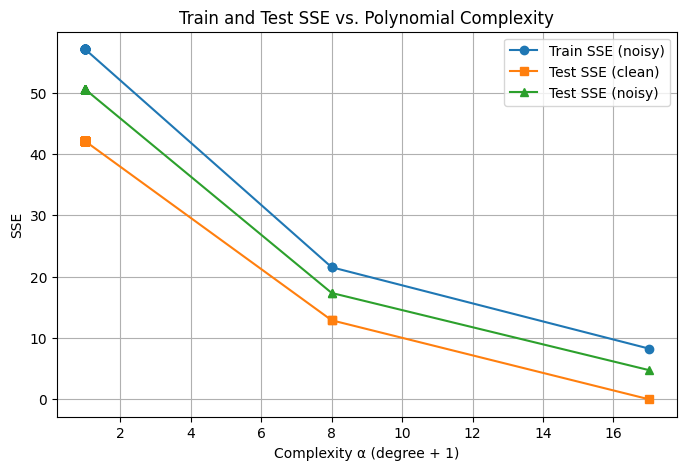

In [ ]:
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate sample data: sin(nπx) with noise
N = 200
x = np.linspace(0, 1, N)
y_clean = np.sin(6 * np.pi * x)
noise = np.random.normal(scale=0.3, size=N)
y_noisy = y_clean + noise

# Split into train/test
indices = list(range(N))
random.shuffle(indices)
split = int(0.6 * N)
train_idx = indices[:split]
test_idx = indices[split:]

# SSE for polynomial of degree d on given indices
def compute_sse(d, y, idx):
    coeffs = np.polyfit(x[idx], y[idx], d)
    y_pred = np.polyval(coeffs, x[idx])
    return np.sum((y[idx] - y_pred) ** 2)

# Annealing over d in [0,15] minimizing action on train data
def anneal(lam, d_max=15, T0=1.0, alpha=0.995, steps=2000):
    d = random.randint(0, d_max)
    T = T0
    sse_train = compute_sse(d, y_noisy, train_idx)
    for _ in range(steps):
        d2 = d + random.choice([-1, 1])
        if not (0 <= d2 <= d_max):
            continue
        sse2 = compute_sse(d2, y_noisy, train_idx)
        A1 = lam * (d + 1) + sse_train
        A2 = lam * (d2 + 1) + sse2
        if A2 < A1 or random.random() < math.exp(-(A2 - A1) / T):
            d, sse_train = d2, sse2
        T *= alpha
    return d, sse_train

# Sweep λ and collect train/test errors
lambdas = np.linspace(0, 200, 42)
alphas, train_errs, test_errs_clean, test_errs_noisy = [], [], [], []

for lam in lambdas:
    d_opt, sse_train = anneal(lam, d_max=16, T0=1.0, alpha=0.995, steps=1000)
    alphas.append(d_opt + 1)
    train_errs.append(sse_train)
    # evaluate on test set against clean function
    test_errs_clean.append(compute_sse(d_opt, y_clean, test_idx))
    # evaluate on test set against noisy data
    test_errs_noisy.append(compute_sse(d_opt, y_noisy, test_idx))

alphas = np.array(alphas)
train_errs = np.array(train_errs)
test_errs_clean = np.array(test_errs_clean)
test_errs_noisy = np.array(test_errs_noisy)

idx = np.argsort(alphas)
alphas = alphas[idx]
train_errs = train_errs[idx]
test_errs_clean = test_errs_clean[idx]
test_errs_noisy = test_errs_noisy[idx]

# Plot training vs test SSE
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errs, marker='o', label='Train SSE (noisy)')
plt.plot(alphas, test_errs_clean, marker='s', label='Test SSE (clean)')
plt.plot(alphas, test_errs_noisy, marker='^', label='Test SSE (noisy)')
plt.xlabel('Complexity α (degree + 1)')
plt.ylabel('SSE')
plt.title('Train and Test SSE vs. Polynomial Complexity')
plt.legend()
plt.grid(True)
plt.show()

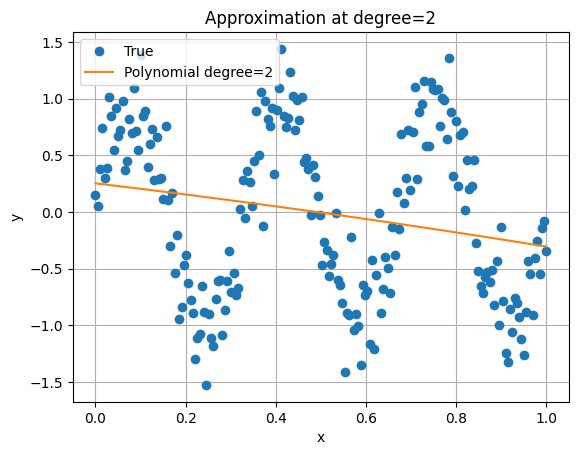

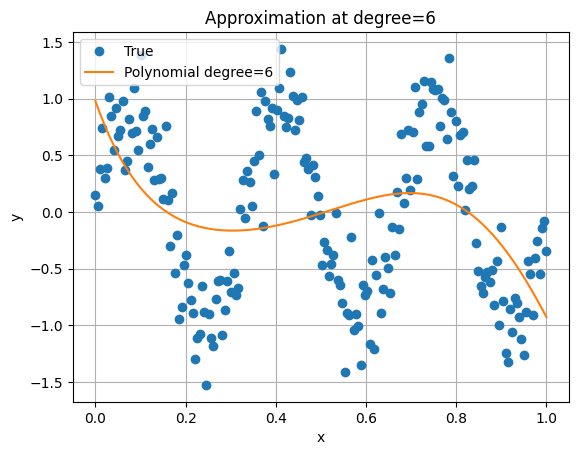

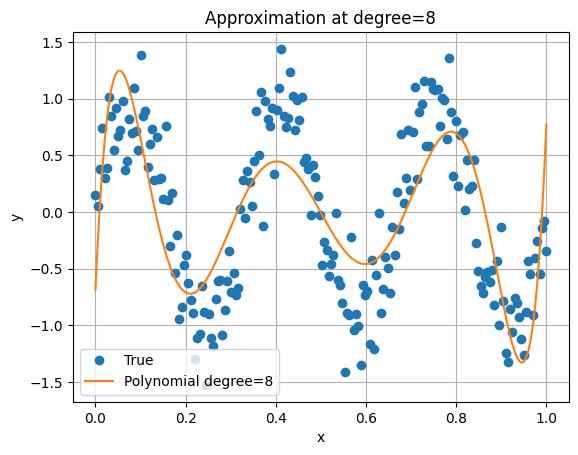

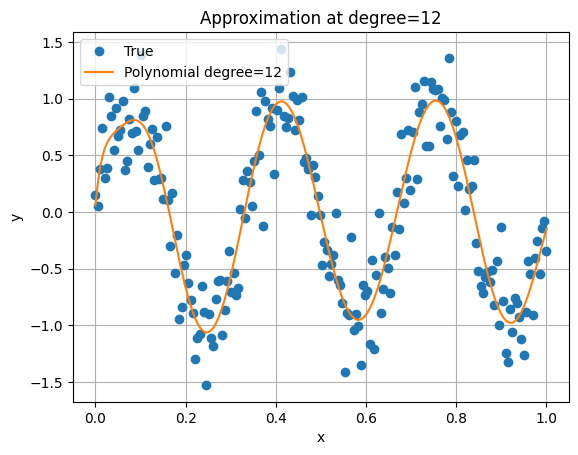

In [ ]:
def plot_approximation(degree, x, y):
    # Fit polynomial and predict
    coeffs = np.polyfit(x, y, degree)
    y_pred = np.polyval(coeffs, x)
    # Plot
    plt.figure()
    plt.plot(x, y, marker='o', linestyle='None', label='True')
    plt.plot(x, y_pred, label=f'Polynomial degree={degree}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Approximation at degree={degree}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for degrees
for deg in [2, 6, 8, 12]:
    plot_approximation(deg, x, y_noisy)

## Fourier Series

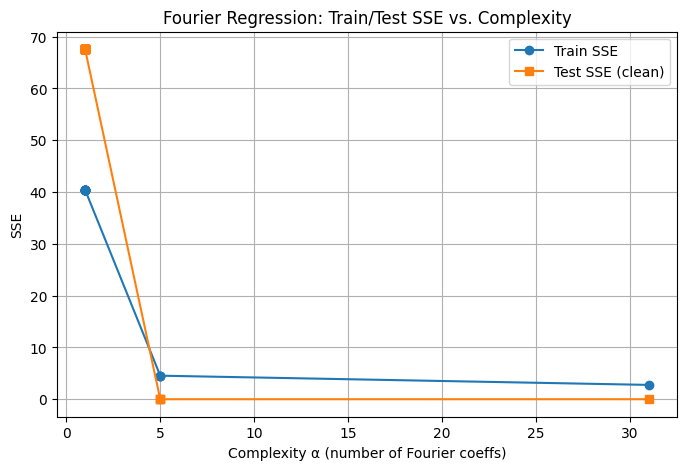

In [ ]:
# Seed for reproducibility
np.random.seed(0)
random.seed(0)

# Generate data
N = 200
x = np.linspace(0, 1, N)
y_clean = np.sin(4 * np.pi * x)
noise_train = np.random.normal(scale=0.3, size=N)
y_noisy = y_clean + noise_train

# Split into train/test
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.3 * N)  # small train set to accentuate overfit
train_idx = indices[:split]
test_idx = indices[split:]

x_train, y_train = x[train_idx], y_noisy[train_idx]
x_test, y_test = x[test_idx], y_clean[test_idx]  # test against clean

# Build Fourier features
def fourier_design(x, K):
    # features: [1, sin(2πk x), cos(2πk x) for k=1..K]
    F = [np.ones_like(x)]
    for k in range(1, K+1):
        F.append(np.sin(2 * np.pi * k * x))
        F.append(np.cos(2 * np.pi * k * x))
    return np.vstack(F).T

# SSE for Fourier model of complexity K
def compute_sse_fourier(K, x_, y_):
    X = fourier_design(x_, K)
    coeffs, *_ = np.linalg.lstsq(X, y_, rcond=None)
    y_pred = X.dot(coeffs)
    return np.sum((y_ - y_pred)**2)

# Annealing: choose K in [0..15]
def anneal_fourier(lam, K_max=15, T0=1.0, alpha=0.995, steps=2000):
    K = random.randint(0, K_max)
    T = T0
    sse = compute_sse_fourier(K, x_train, y_train)
    for _ in range(steps):
        K2 = K + random.choice([-1, 1])
        if not (0 <= K2 <= K_max): continue
        sse2 = compute_sse_fourier(K2, x_train, y_train)
        A1 = lam * (2*K+1) + sse
        A2 = lam * (2*K2+1) + sse2
        if A2 < A1 or random.random() < math.exp(-(A2 - A1) / T):
            K, sse = K2, sse2
        T *= alpha
    return K, sse

# Sweep λ and measure train/test SSE
lambdas = np.linspace(0, 100, 21)
alphas, train_errs, test_errs = [], [], []

for lam in lambdas:
    K_opt, sse_tr = anneal_fourier(lam)
    alphas.append(2*K_opt + 1)
    train_errs.append(sse_tr)
    test_errs.append(compute_sse_fourier(K_opt, x_test, y_test))

plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errs, marker='o', label='Train SSE')
plt.plot(alphas, test_errs, marker='s', label='Test SSE (clean)')
plt.xlabel('Complexity α (number of Fourier coeffs)')
plt.ylabel('SSE')
plt.title('Fourier Regression: Train/Test SSE vs. Complexity')
plt.legend()
plt.grid(True)
plt.show()


---

# Tree-based models

## Tree regressor with Simulated Annealing

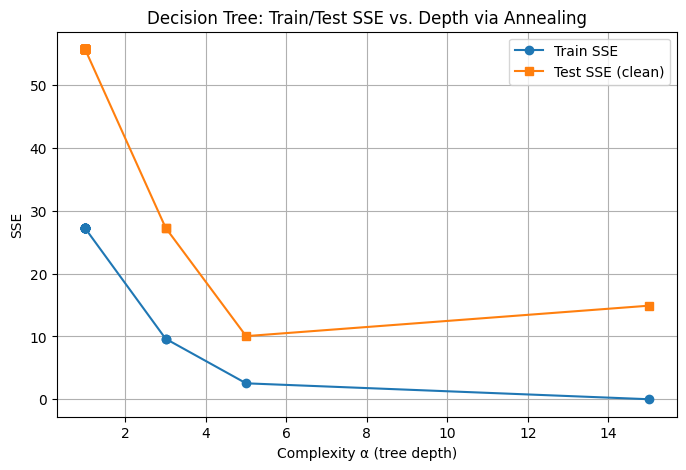

In [ ]:
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate data
N = 200
x = np.linspace(0, 1, N).reshape(-1, 1)
y_clean = np.sin(4 * np.pi * x).ravel()

# Add independent noise to create train/test labels
noise_train = np.random.normal(scale=0.3, size=N)
noise_test = np.random.normal(scale=0.3, size=N)

# Split indices (30% train, 70% test)
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.3 * N)
train_idx = indices[:split]
test_idx = indices[split:]

x_train, y_train_noisy = x[train_idx], y_clean[train_idx] + noise_train[train_idx]
x_test, y_test_clean = x[test_idx], y_clean[test_idx]

# SSE computation
def sse_train(depth):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(x_train, y_train_noisy)
    preds = dt.predict(x_train)
    return np.sum((y_train_noisy - preds) ** 2)

def sse_test(depth):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(x_train, y_train_noisy)
    preds = dt.predict(x_test)
    return np.sum((y_test_clean - preds) ** 2)

# Annealing over tree depth
def anneal_tree(lam, depth_max=15, T0=1.0, alpha=0.995, steps=2000):
    depth = random.randint(1, depth_max)
    T = T0
    sse_tr = sse_train(depth)
    for _ in range(steps):
        depth2 = depth + random.choice([-1, 1])
        if not (1 <= depth2 <= depth_max):
            continue
        sse2 = sse_train(depth2)
        A1 = lam * depth + sse_tr
        A2 = lam * depth2 + sse2
        if A2 < A1 or random.random() < math.exp(-(A2 - A1) / T):
            depth, sse_tr = depth2, sse2
        T *= alpha
    return depth, sse_tr

# Sweep lambda to find optimal depth, record SSEs
lambdas = np.linspace(0, 50, 21)
alphas = []
train_errs = []
test_errs = []

for lam in lambdas:
    d_opt, sse_tr = anneal_tree(lam)
    alphas.append(d_opt)
    train_errs.append(sse_tr)
    test_errs.append(sse_test(d_opt))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errs, marker='o', label='Train SSE')
plt.plot(alphas, test_errs, marker='s', label='Test SSE (clean)')
plt.xlabel('Complexity α (tree depth)')
plt.ylabel('SSE')
plt.title('Decision Tree: Train/Test SSE vs. Depth via Annealing')
plt.legend()
plt.grid(True)
plt.show()

## Tree Regressor with HyperOpt

100%|██████████| 50/50 [00:00<00:00, 310.95trial/s, best loss: 9.862906922049524]


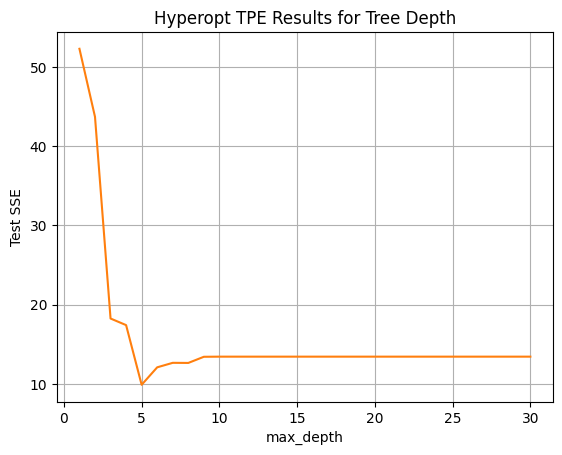

Best depth: 5


In [74]:
# Generate data
N = 200
x = np.linspace(0, 1, N).reshape(-1, 1)
y_clean = np.sin(4 * np.pi * x).ravel()

# Add independent noise to create train/test labels
noise_train = np.random.normal(scale=0.3, size=N)
noise_test = np.random.normal(scale=0.3, size=N)

# Split indices (30% train, 70% test)
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.3 * N)
train_idx = indices[:split]
test_idx = indices[split:]

x_train, y_train_noisy = x[train_idx], y_clean[train_idx] + noise_train[train_idx]
x_test, y_test_clean = x[test_idx], y_clean[test_idx]

# Objective for Hyperopt: fit DT, return test SSE
def objective(params):
    d = int(params['max_depth'])
    model = DecisionTreeRegressor(max_depth=d, random_state=0)
    model.fit(x_train, y_train_noisy)
    y_pred = model.predict(x_test)
    sse = np.sum((y_pred - y_test_clean)**2)
    return {'loss': sse, 'status': STATUS_OK}

# Search space: depths 1..30
space = {'max_depth': hp.quniform('max_depth', 1, 30, 1)}

# Run TPE for, say, 50 evaluations
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Extract results
depths = [int(t['misc']['vals']['max_depth'][0]) for t in trials.trials]
losses = [t['result']['loss'] for t in trials.trials]
depths = np.array(depths)
losses = np.array(losses)
idx = np.argsort(depths)
depths = depths[idx]
losses = losses[idx]

# Plot test SSE vs chosen depth
plt.plot(depths, losses, c='C1')
plt.xlabel('max_depth')
plt.ylabel('Test SSE')
plt.title('Hyperopt TPE Results for Tree Depth')
plt.grid(True)
plt.show()

print("Best depth:", int(best['max_depth']))

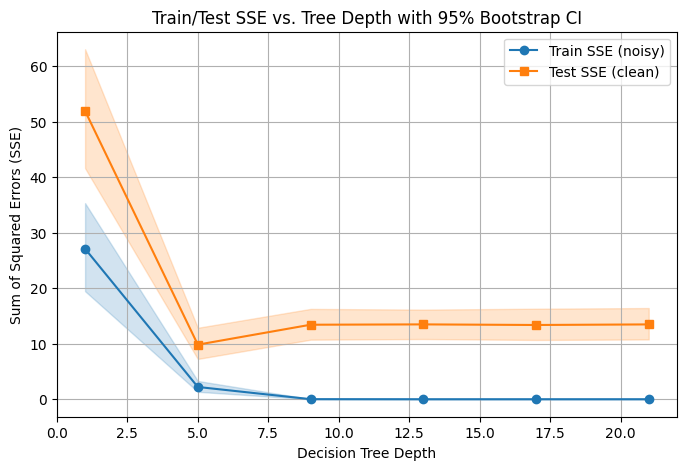

In [78]:
# Unique depths to evaluate
max_depths = range(1, 24, 4)
n_test = len(x_test)
B = 1000  # bootstrap replicates

# Preallocate arrays
test_sse_mean = []
test_sse_lower = []
test_sse_upper = []
train_sse_mean = []
train_sse_lower = []
train_sse_upper = []

# For each depth, fit model and bootstrap SSE
for d in max_depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=0)
    # Fit on noisy train data
    model.fit(x_train, y_train_noisy)
    # Predictions
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    # Bootstrap SSE on test (clean) and train (noisy)
    test_sse_bs = []
    train_sse_bs = []
    for _ in range(B):
        # bootstrap sample indices
        idx_test_bs = np.random.choice(n_test, size=n_test, replace=True)
        idx_train_bs = np.random.choice(len(x_train), size=len(x_train), replace=True)
        # compute SSEs
        test_sse_bs.append(np.sum((y_test_clean[idx_test_bs] - y_pred_test[idx_test_bs])**2))
        train_sse_bs.append(np.sum((y_train_noisy[idx_train_bs] - y_pred_train[idx_train_bs])**2))
    # Statistics
    test_sse_bs = np.array(test_sse_bs)
    train_sse_bs = np.array(train_sse_bs)
    test_sse_mean.append(test_sse_bs.mean())
    test_sse_lower.append(np.percentile(test_sse_bs, 2.5))
    test_sse_upper.append(np.percentile(test_sse_bs, 97.5))
    train_sse_mean.append(train_sse_bs.mean())
    train_sse_lower.append(np.percentile(train_sse_bs, 2.5))
    train_sse_upper.append(np.percentile(train_sse_bs, 97.5))

# Plot with 95% CI shading
plt.figure(figsize=(8, 5))
plt.plot(max_depths, train_sse_mean, marker='o', label='Train SSE (noisy)')
plt.fill_between(max_depths, train_sse_lower, train_sse_upper, color='C0', alpha=0.2)
plt.plot(max_depths, test_sse_mean, marker='s', label='Test SSE (clean)')
plt.fill_between(max_depths, test_sse_lower, test_sse_upper, color='C1', alpha=0.2)
plt.xlabel('Decision Tree Depth')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Train/Test SSE vs. Tree Depth with 95% Bootstrap CI')
plt.legend()
plt.grid(True)
plt.show()

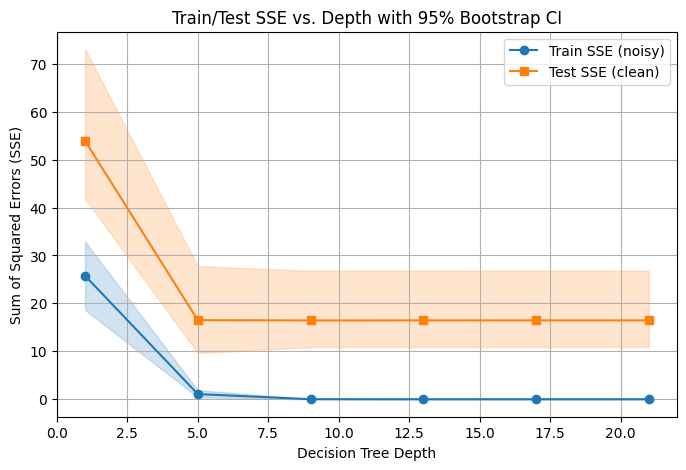

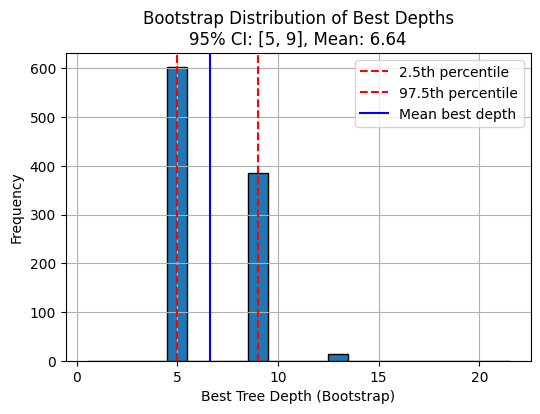

Bootstrap best depth mean = 6.64, 95% CI = [5, 9]


In [80]:
# Parameters
depths = np.arange(1, 24, 4)
B = 1000  # number of bootstrap replicates

# Arrays to store bootstrap SSEs and best depths
SSEs_train = np.zeros((B, depths.size))
SSEs_test = np.zeros((B, depths.size))
best_depths = np.zeros(B, dtype=int)

for b in range(B):
    # Bootstrap indices for train and test sets
    train_idx_bs = np.random.choice(len(x_train), size=len(x_train), replace=True)
    test_idx_bs = np.random.choice(len(x_test), size=len(x_test), replace=True)

    for i, d in enumerate(depths):
        model = DecisionTreeRegressor(max_depth=d, random_state=0)
        # Fit on bootstrapped train data (noisy)
        model.fit(x_train[train_idx_bs], y_train_noisy[train_idx_bs])
        # Predict on train and test
        y_pred_train = model.predict(x_train[train_idx_bs])
        y_pred_test = model.predict(x_test[test_idx_bs])
        # Compute SSEs
        SSEs_train[b, i] = np.sum((y_train_noisy[train_idx_bs] - y_pred_train) ** 2)
        SSEs_test[b, i] = np.sum((y_test_clean[test_idx_bs] - y_pred_test) ** 2)

    # Best depth for this bootstrap replicate (min test SSE)
    best_depths[b] = depths[np.argmin(SSEs_test[b])]

# Compute SSE statistics
train_sse_mean = SSEs_train.mean(axis=0)
train_sse_lower = np.percentile(SSEs_train, 2.5, axis=0)
train_sse_upper = np.percentile(SSEs_train, 97.5, axis=0)
test_sse_mean = SSEs_test.mean(axis=0)
test_sse_lower = np.percentile(SSEs_test, 2.5, axis=0)
test_sse_upper = np.percentile(SSEs_test, 97.5, axis=0)

# Compute best-depth CI
ci_lower = np.percentile(best_depths, 2.5)
ci_upper = np.percentile(best_depths, 97.5)
mean_best_depth = best_depths.mean()

# Plot 1: SSE vs depth with 95% CI shading
plt.figure(figsize=(8, 5))
plt.plot(depths, train_sse_mean, marker='o', label='Train SSE (noisy)')
plt.fill_between(depths, train_sse_lower, train_sse_upper, color='C0', alpha=0.2)
plt.plot(depths, test_sse_mean, marker='s', label='Test SSE (clean)')
plt.fill_between(depths, test_sse_lower, test_sse_upper, color='C1', alpha=0.2)
plt.xlabel('Decision Tree Depth')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Train/Test SSE vs. Depth with 95% Bootstrap CI')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Histogram of best depths
plt.figure(figsize=(6, 4))
plt.hist(best_depths, bins=np.arange(depths.min(), depths.max()+2)-0.5, edgecolor='black')
plt.axvline(ci_lower, color='red', linestyle='--', label='2.5th percentile')
plt.axvline(ci_upper, color='red', linestyle='--', label='97.5th percentile')
plt.axvline(mean_best_depth, color='blue', linestyle='-', label='Mean best depth')
plt.xlabel('Best Tree Depth (Bootstrap)')
plt.ylabel('Frequency')
plt.title(f'Bootstrap Distribution of Best Depths\n95% CI: [{ci_lower:.0f}, {ci_upper:.0f}], Mean: {mean_best_depth:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# Print CI results
print(f"Bootstrap best depth mean = {mean_best_depth:.2f}, 95% CI = [{ci_lower:.0f}, {ci_upper:.0f}]")


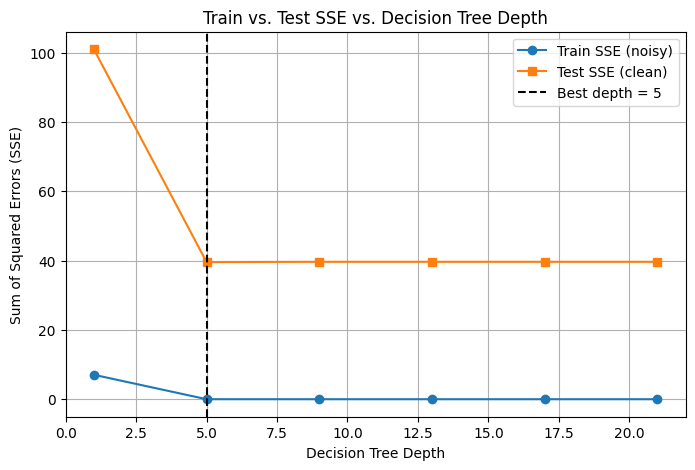

In [69]:
# Grid search over tree depths
max_depths = range(1, 24, 4)
train_sse = []
test_sse = []

for d in max_depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=0)
    model.fit(x_train, y_train_noisy)
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    train_sse.append(np.sum((y_train_noisy - train_pred) ** 2))
    test_sse.append(np.sum((y_test_clean - test_pred) ** 2))

# Identify best depth where test SSE is minimal
best_depth = max_depths[int(np.argmin(test_sse))]

# Plot train/test SSE vs depth
plt.figure(figsize=(8, 5))
plt.plot(max_depths, train_sse, marker='o', label='Train SSE (noisy)')
plt.plot(max_depths, test_sse, marker='s', label='Test SSE (clean)')
plt.axvline(best_depth, color='k', linestyle='--', label=f'Best depth = {best_depth}')
plt.xlabel('Decision Tree Depth')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Train vs. Test SSE vs. Decision Tree Depth')
plt.legend()
plt.grid(True)
plt.show()
